### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [2]:
print('here...')

here...


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
!ls -ltrh /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome*

-rwxrwxr-x 1 ilibarra ilibarra 1.8M Jun 10 10:55 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_0.pth
-rwxrwxr-x 1 ilibarra ilibarra 1.8M Jun 10 10:55 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_1.pth
-rw-rw-r-- 1 ilibarra ilibarra 1.8M Jun 11 00:03 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_0_obs480.pth
-rw-rw-r-- 1 ilibarra ilibarra 1.8M Jun 11 00:03 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_1_obs480.pth
-rw-rw-r-- 1 ilibarra ilibarra 2.7M Jun 11 00:19 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_0_obs912.pth
-rw-rw-r-- 1 ilibarra ilibarra 2.8M Jun 11 00:19 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/pancreas_multiome_use_logdynamic_1_obs912.pth
-rw-rw-r-- 1 ilibarra ilibarra 9.8M 

In [6]:
# pip install matplotlib==3.7.2

In [7]:
import torch
import mubind as mb
import scanpy as sc

In [8]:
# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = "pancreas_multiome_use_logdynamic_%i_obs4148.pth" % use_logdynamic
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

pancreas_multiome_use_logdynamic_0_obs4148.pth
pancreas_multiome_use_logdynamic_1_obs4148.pth


In [9]:
!ls -ltrh /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/atac_train*

-rw-rw-r-- 1 ilibarra ilibarra 24M Jun 11 20:19 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/atac_train.h5ad


In [10]:
ad = sc.read_h5ad("atac_train.h5ad")
rna_sample = sc.read_h5ad("rna_sample_train.h5ad")

In [11]:
import pickle


train = pickle.load(open("train_dataloader.pkl", "rb"))

In [12]:
%load_ext line_profiler

In [22]:
!readlink -f .

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


In [26]:
# load the pancreas multiome dataset
rna, atac = mb.datasets.pancreas_multiome(data_directory="../../../../../../annotations/single_cell")

True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_rna_velocities_2024.h5ad
True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_atac.h5ad


In [27]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [28]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [29]:
import matplotlib.pyplot as plt

In [30]:
cell_type_key = "celltype"

Graph Layer |  False
True
3
order None
0 out of 288...
break


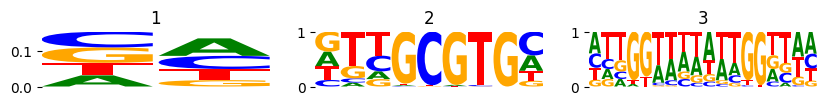

Graph Layer |  True
True
3
order None
0 out of 288...
break


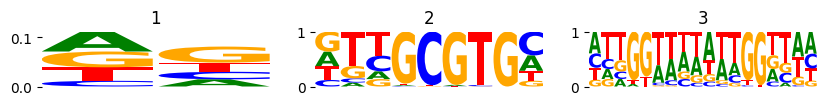

In [31]:
for optimize_log_dynamic in model_by_logdynamic:
    print("Graph Layer | ", optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # print(optimize_log_dynamic)
    from matplotlib import rcParams

    rcParams["figure.figsize"] = 10, 5
    rcParams["figure.dpi"] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4)  #  log=True)
    plt.show()

True


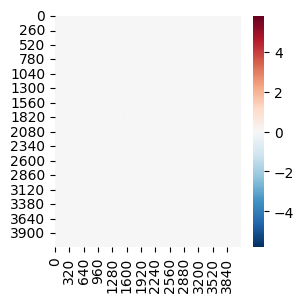

In [32]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns

    mb.pl.set_rcParams({"figure.figsize": [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap="RdBu_r")
    plt.show()

In [33]:
model = model_by_logdynamic[1]

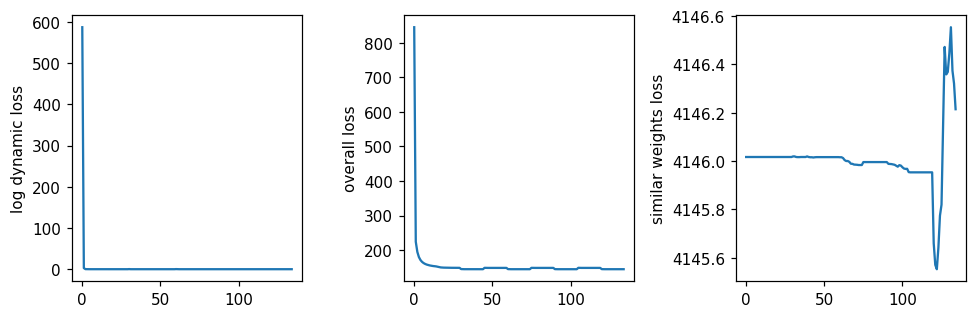

In [34]:
mb.pl.set_rcParams({"figure.figsize": [12, 3], "figure.dpi": 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel("log dynamic loss")
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel("overall loss")
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel("similar weights loss")
plt.tight_layout()
plt.show()

In [35]:
import pandas as pd
import numpy as np

False
True


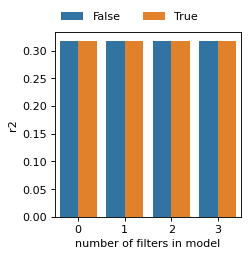

In [36]:
rcParams["figure.figsize"] = 3, 5
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns

    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=["r2"]).reset_index()
        r2["opt_log_dynamic"] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams["figure.figsize"] = 3, 3
    rcParams["figure.dpi"] = 80
    ax = sns.barplot(
        data=r2_all,
        x="index",
        y="r2",
        hue="opt_log_dynamic",
    )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.4, 1), ncol=3, title=None, frameon=False)

    plt.xlabel("number of filters in model")
    plt.show()

In [37]:
model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs["dynamic_score"] = dynamic_score

ad.obs["dynamic_score_cluster"] = np.where(dynamic_score > dynamic_score.mean(), "dynamic", "static")
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, "dynamic", "static")
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, "dynamic", "static")

ad.obs["dynamic_score_z1"] = z1
ad.obs["dynamic_score_z2"] = z2

In [38]:
ad.obs["dynamic_score"].describe()

count    4148.000000
mean        0.486606
std         0.039733
min         0.000000
25%         0.486571
50%         0.486606
75%         0.486617
max         1.000000
Name: dynamic_score, dtype: float64

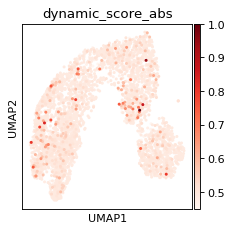

In [39]:
ad.obs["dynamic_score_abs"] = ad.obs["dynamic_score"].abs()
sc.pl.umap(ad, color="dynamic_score_abs", color_map="Reds", vmin=0.45)

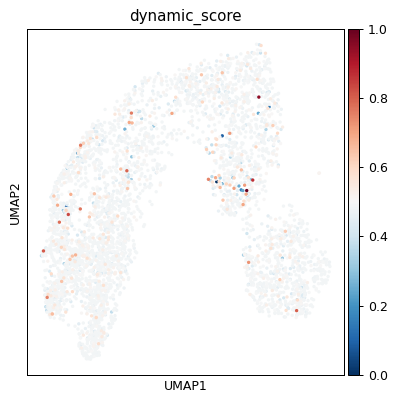

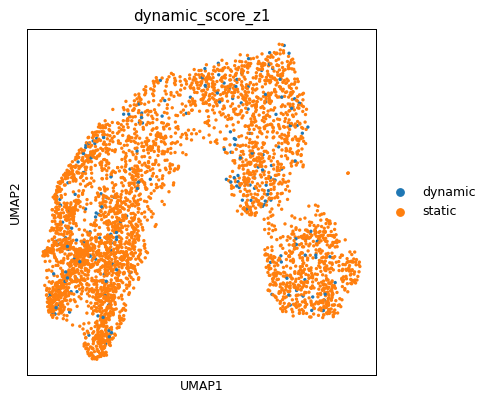

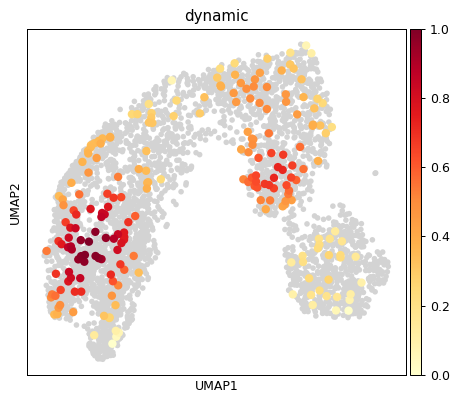

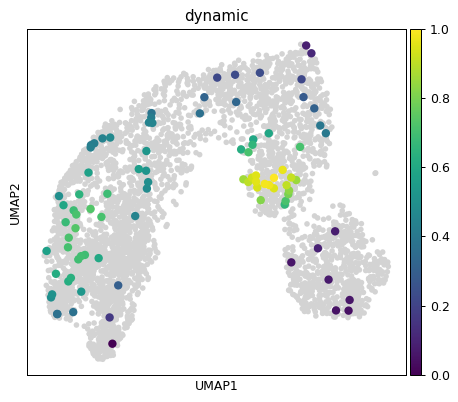

In [40]:
# contributions per newly added kernel
mb.pl.set_rcParams({"figure.figsize": [5, 5], "figure.dpi": 90})
sc.pl.umap(ad, color=["dynamic_score"], cmap="RdBu_r", sort_order=True)
sc.pl.umap(ad, color=["dynamic_score_z1"], cmap="RdBu_r", sort_order=True)

sc.tl.embedding_density(ad, basis="umap", groupby="dynamic_score_z1")
sc.pl.embedding_density(
    ad, basis="umap", key="umap_density_dynamic_score_z1", group="dynamic"
)  # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis="umap", groupby="dynamic_score_z2")
sc.pl.embedding_density(
    ad, basis="umap", key="umap_density_dynamic_score_z2", group="dynamic", color_map="viridis"
)  # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

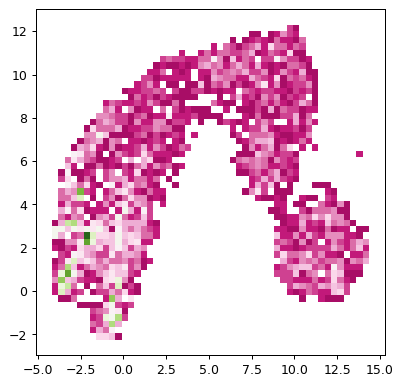

In [41]:
import seaborn as sns

umap = ad.obsm["X_umap"]
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap="PiYG")

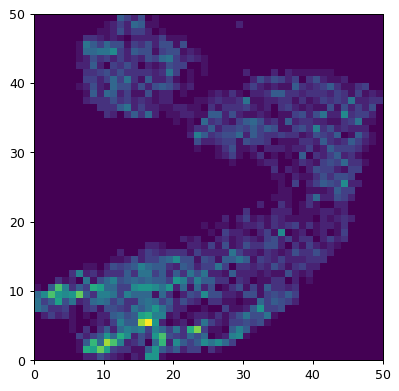

In [42]:
plt.pcolormesh(np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0])

In [43]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [44]:
x = umap[:, 1]  # array_txt[:,0]
y = umap[:, 1]  # array_txt[:,1]
z = ad.obs["dynamic_score"].values  # array_txt[:,2]

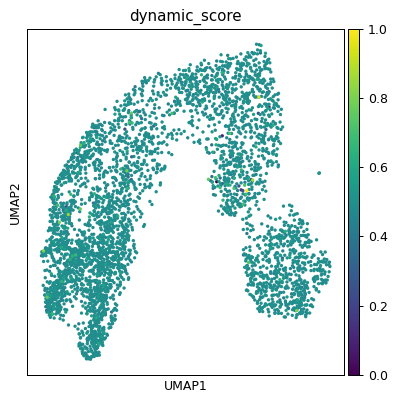

In [45]:
sc.pl.umap(ad, color="dynamic_score")

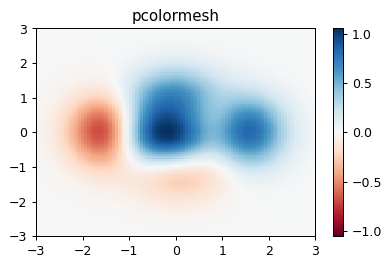

In [46]:
import matplotlib.pyplot as plt
import numpy as np

rcParams["figure.figsize"] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2.0 + x**5 + y**3) * np.exp(-(x**2) - y**2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap="RdBu", vmin=z_min, vmax=z_max)
ax.set_title("pcolormesh")
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [47]:
import itertools
import numpy as np


def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)

In [48]:
grid_dyn_score = grid(umap[:, 0], umap[:, 1], ad.obs["dynamic_score"], size_x=1, size_y=1)
grid_counts = grid(umap[:, 0], umap[:, 1], ad.obs["celltype"].cat.codes.values, size_x=1, size_y=1)

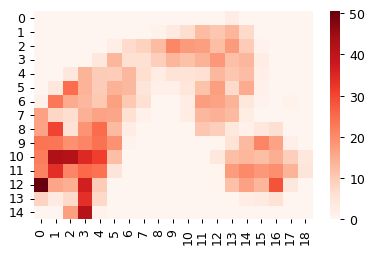

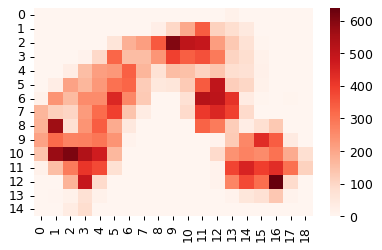

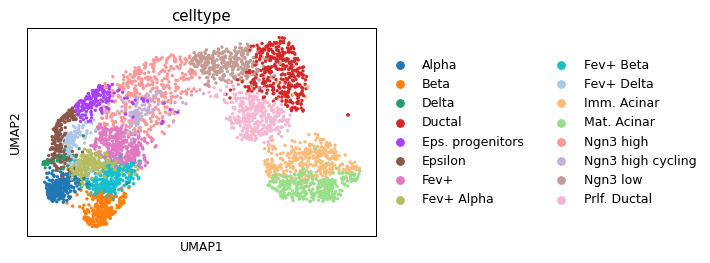

In [49]:
sns.heatmap(grid_dyn_score, cmap="Reds")
plt.show()
sns.heatmap(grid_counts, cmap="Reds")
plt.show()

sc.pl.umap(ad, color="celltype")

In [50]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()

In [51]:
model = model_by_logdynamic[True]

In [52]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense()  # (C, C)

In [53]:
# number of non_zero weights
len(G[G != 0])

36316

In [54]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [55]:
print("here...")

here...


In [56]:
ad

AnnData object with n_obs × n_vars = 4148 × 7200
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'modality', 'acc_score', 'acc_score_rank', 'chr', 'start', 'end', 'summit', 'summit.start', 'summit.end', 'k.summit'
    uns: 'celltype_colors', 'neighbors', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectiviti

In [57]:
model = model.cuda()

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [59]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic].cuda()

    umap = ad.obsm["X_umap"].copy()
    umap = np.sort(umap, 0)

    x = umap[:, 0]
    y = umap[:, 1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum, "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs["scale_countsum"] = model.datatype == "selex"
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print("here...")
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T

    # ad.layers['velocity'] = pred

    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()

    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']

    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True
here...
(128, 4148)
1229174300000.0
here...
(128, 4148)
1604601400000.0
here...
(128, 4148)
1309958900000.0
here...
(128, 4148)
1021111500000.0
here...
(128, 4148)
1254264900000.0
here...
(128, 4148)
784260460000.0
here...
(128, 4148)
1583512200000.0
here...
(128, 4148)
1182601700000.0
here...
(128, 4148)
1294851600000.0
here...
(128, 4148)
1223608200000.0
here...
(128, 4148)
1326263300000.0
here...
(128, 4148)
1432266000000.0
here...
(128, 4148)
1640859700000.0
here...
(128, 4148)
1317058100000.0
here...
(128, 4148)
2086314700000.0
here...
(128, 4148)
1188217900000.0
here...
(128, 4148)
1627706400000.0
here...
(128, 4148)
1494880500000.0
here...
(128, 4148)
905376600000.0
here...
(128, 4148)
1803660000000.0
here...
(128, 4148)
1523784200000.0
here...
(128, 4148)
959463100000.0
here...
(128, 4148)
1339082300000.0
here...
(128, 4148)
1284601800000.0
here...
(128, 4148)
1358734700000.0
here...
(128, 4148)
1107306000000.0
here...
(128, 4148)
991597170000.0
here...
(128, 4148)
1

In [60]:
import scvelo as scv

In [61]:
ad
ad.layers["velocity"] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [62]:
np.random.shuffle(binding_scores)
binding_scores

array([[1615340.8, 1766662.6, 2680959.8, ..., 2392485.2, 2472441.2,
        2260345.8],
       [1611704.8, 1761850.2, 2665986.5, ..., 2385924.2, 2469953. ,
        2255595.2],
       [1613898. , 1764396.9, 2673350.5, ..., 2392381. , 2474374.5,
        2260948. ],
       ...,
       [1608042.2, 1756466.6, 2659900.8, ..., 2379668. , 2464914. ,
        2250139. ],
       [1615700.2, 1767083.4, 2681737.2, ..., 2393477. , 2473499.2,
        2261271.2],
       [1615722.6, 1767129. , 2681665.8, ..., 2393242.5, 2473330. ,
        2261063.2]], dtype=float32)

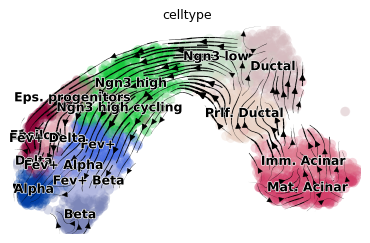

In [63]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color="celltype")
except Exception:
    print("sample too small.")

In [64]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

<Axes: >

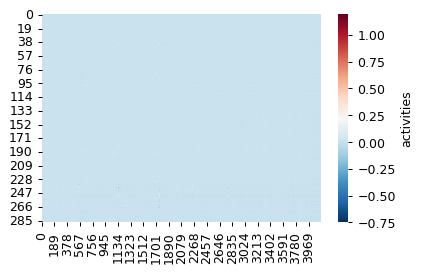

In [65]:
import seaborn as sns


act = model.get_log_activities().detach().cpu().squeeze(0)

sns.heatmap(act, cmap="RdBu_r", cbar_kws={"label": "activities"})

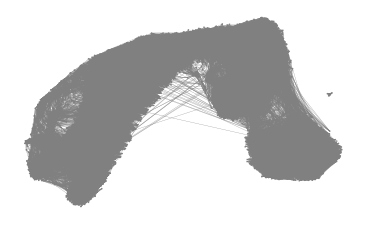

In [66]:
scv.pl.velocity_graph(rna)

In [67]:
# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [68]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [69]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

## Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [70]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 4148 × 14663
     obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch', 'velocity_self_transition'
     var: 'modality', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
     uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
     obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX', 'velocity_umap'
     layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced',

In [71]:
rna_sel = rna_sample  # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(4148, 14663)

In [72]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [73]:
import bindome as bd


bd.constants.ANNOTATIONS_DIRECTORY = "annotations"



anno = mb.datasets.archetypes_anno()

In [74]:
rna_sel.shape
anno.sort_values("Cluster_ID")

Cluster_ID          Name          DBD             Seed_motif  \
61            1          HD/1  homeodomain     LHX6_homeodomain_3   
72            2          HD/2  homeodomain          ALX3_MA0634.1   
79            3          HD/3  homeodomain    VENTX_homeodomain_2   
80            4          HD/4  homeodomain  BARX1_MOUSE.H11MO.0.C   
81            5          HD/5  homeodomain    BARX1_homeodomain_1   
..          ...           ...          ...                    ...   
163         282         PAX/2          PAX   PAX5_HUMAN.H11MO.0.A   
161         283  PAX-halfsite          PAX          Pax2_MA0067.1   
0           284           AHR         bHLH    AHR_HUMAN.H11MO.0.B   
105         285      KLF/SP/3         C2H2   KLF8_HUMAN.H11MO.0.C   
285         286        ZSCAN4         C2H2          ZSCAN4_C2H2_1   

     Total_width  Consensus_left  Consensus_right  Cluster_size  
61            12               0               12             2  
72            26               8               16           186  
79            21               3               20             1  
80            17               5               13            17  
81            21               2               18             6  
..           ...             ...              ...           ...  
163           24               4               21             3  
161            8               1                7             1  
0              9               2                8             3  
105            9               0                9             2  
285           15               1               14             2  

[286 rows x 8 columns]

False


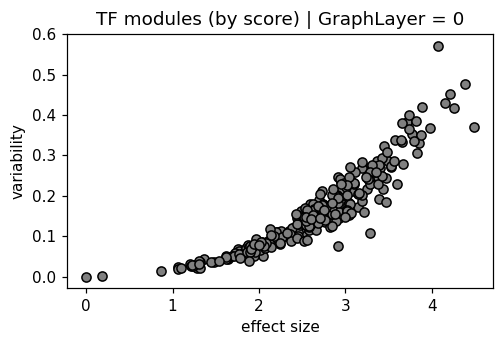

True


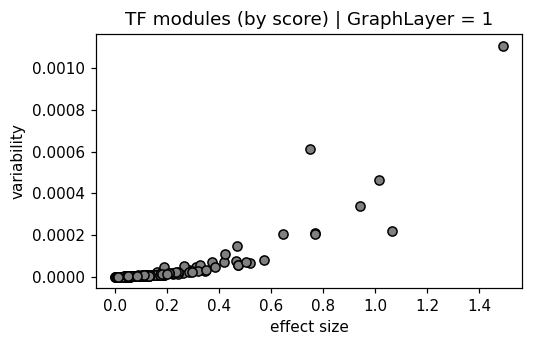

In [75]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm["mubind_activities"] = log_act

    mb.pl.set_rcParams({"figure.figsize": [5, 3], "figure.dpi": 110})
    delta = log_act.max(axis=0) - log_act.min(axis=0)
    var = log_act.var(axis=0)
    plt.scatter(delta, var, color="gray", edgecolors="black")
    plt.xlabel("effect size")
    plt.ylabel("variability")
    plt.title("TF modules (by score) | GraphLayer = %i" % optimize_log_dynamic)
    plt.show()

In [76]:
# unique names for annotation
names = anno["Name"]  # .sort_values('Name')
added = dict()
new_name = []
for name in names:
    if not name in added:
        new_name.append(name)
        added[name] = 0
    else:
        new_name.append(name + "_%i" % added[name])
        added[name] += 1
anno["Name_unique"] = new_name

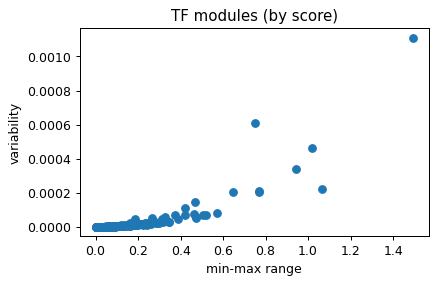

In [77]:
from scipy.stats import spearmanr


res = []

for optimize_log_dynamic in model_by_logdynamic:

    if not optimize_log_dynamic:
        continue


    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T

    log_act = pd.DataFrame(log_act.detach().cpu().numpy())

    # log_act.columns = anno['Seed_motif'][2]

    log_act.columns = ["intercept", "dinuc_bias"] + list(range(1, 287))

    log_act.index = ad.obs_names

    ad.obsm["mubind_activities"] = log_act


    mb.pl.set_rcParams({"figure.figsize": [5, 3], "figure.dpi": 90})

    delta = log_act.max(axis=0) - log_act.min(axis=0)

    var = log_act.var(axis=0)

    plt.scatter(delta, var)

    plt.xlabel("min-max range")

    plt.ylabel("variability")

    plt.title("TF modules (by score)")

    plt.show()


    for c in log_act:

        a = log_act[c]

        b = ad.obs["dynamic_score"].values

        # print(a.shape, b.shape)

        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))


res = pd.DataFrame(res, columns=["opt_log_dynamic", "archetype_id", "spearman", "p_val"])

In [78]:
# add archetypes name
meta = pd.DataFrame(pd.concat([delta, var], axis=1))
meta.columns = ["max_effect", "variability"]
meta["name"] = ["intercept", "dinuc_bias"] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
meta["archetypes_name"] = meta["name"].map(anno.set_index("Cluster_ID")["Name_unique"])
meta["archetypes_name"] = np.where(pd.isnull(meta["archetypes_name"]), meta["name"], meta["archetypes_name"])

meta["archetypes_seed"] = meta["name"].map(anno.set_index("Cluster_ID")["Seed_motif"])
meta = meta.sort_values("max_effect", ascending=0)
meta

res = res.merge(meta, left_on="archetype_id", right_on="name")
res = res.sort_values("p_val", ascending=True)

In [79]:
name_by_filter_id = meta["archetypes_name"].to_dict()
# name_by_filter_id

## Observe general scores per case

<Axes: xlabel='max_effect', ylabel='archetypes_name'>

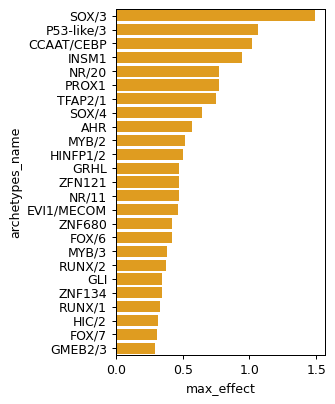

In [80]:
rcParams["figure.figsize"] = 3, 5
sns.barplot(
    data=res.sort_values("max_effect", ascending=False).head(25), x="max_effect", y="archetypes_name", color="orange"
)

In [81]:
res

opt_log_dynamic archetype_id  spearman         p_val  max_effect  \
181             True          180 -0.085108  4.026679e-08    0.121346   
33              True           32  0.057679  2.017768e-04    0.021953   
171             True          170  0.053759  5.326209e-04    0.036565   
244             True          243  0.051078  9.988277e-04    0.316506   
259             True          258  0.050797  1.065286e-03    0.472819   
..               ...          ...       ...           ...         ...   
70              True           69  0.000435  9.776783e-01    0.022655   
200             True          199 -0.000339  9.825946e-01    0.185973   
64              True           63  0.000326  9.832732e-01    0.072349   
188             True          187  0.000169  9.913384e-01    0.013637   
65              True           64 -0.000166  9.914805e-01    0.060838   

      variability name archetypes_name        archetypes_seed  
181  5.851416e-06  180           SIX/1   SIX1_HUMAN.H11MO.0.A  
33   3.194034e-07   32            NR/3   COT1_HUMAN.H11MO.0.C  
171  3.655862e-07  170          BCL6/2   BCL6_HUMAN.H11MO.0.A  
244  2.655000e-05  243           HIC/2   HIC1_HUMAN.H11MO.0.C  
259  5.695755e-05  258            GRHL            GRHL1_CP2_1  
..            ...  ...             ...                    ...  
70   1.215439e-07   69            MIES         MEIS1_MA0498.2  
200  9.662266e-06  199            MFZ1          MZF1_MA0057.1  
64   1.406672e-06   63    Ebox/CAGATGG  ATOH1_HUMAN.H11MO.0.B  
188  6.700983e-08  187           HIC/1            HIC2_C2H2_1  
65   1.111225e-06   64            HEN1   HEN1_HUMAN.H11MO.0.C  

[288 rows x 9 columns]

True
1
order None
0 out of 288...
10 out of 288...
break


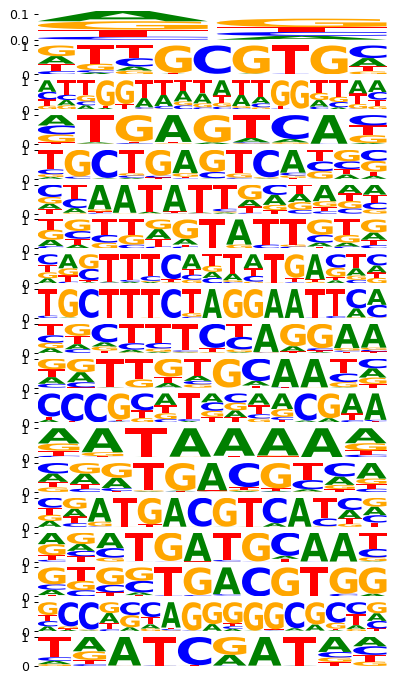

In [82]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({"figure.figsize": [5, 20], "figure.dpi": 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
# n_rows=len(res.head(20).index),

True
1
order Index([181,  33, 171, 244, 259,  10, 183, 246,  97, 216, 142, 271, 163, 238,
       108, 191, 135, 100,  23, 101],
      dtype='int64')
0 out of 288...
10 out of 288...


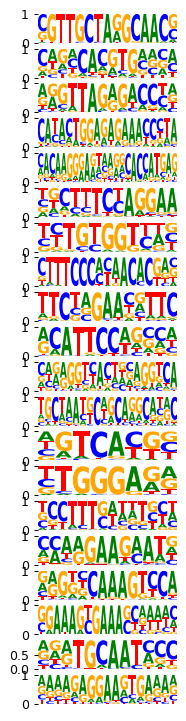

<Figure size 180x1800 with 0 Axes>

In [83]:
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    order=res.head(20).index,
)  # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [84]:
import resource

print("total GB used:", resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)

total GB used: 10.555016


In [85]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')

In [86]:
rna_sel.obsm["X_umap"] = ad.obsm["X_umap"]

In [87]:
def find_varname(ad, k, shuffle=False):
    if not shuffle:
        return ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
    else:
        ad_sel = ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
        return pd.Series(ad.var_names).sample(ad_sel.shape[0]).values

In [88]:
from scipy.stats import spearmanr, pearsonr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [89]:
all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm["log_activities"] = log_act
    ad.obsm["log_activities"].columns = ["intercept", "dinuc_bias"] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm["log_activities"].iloc[:, 2:]:
        log_act = ad.obsm["log_activities"][k].values
        names = set()
        clu_sel = clu[clu["Cluster_ID"] == k]["Motif"]
        for g in clu_sel:
            names.add(g.split("_")[0].split(".")[0].split("+")[0].upper())
        for g in anno[anno["Cluster_ID"] == k]["Seed_motif"]:
            names.add(g.split("_")[0].split(".")[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap="Reds")

False
True


In [90]:

def get_act_gene_corr(model_by_logdynamic, shuffle=False, random_state=0):
    print('association between motif activities and related TF targets (shuffle = %i)' % shuffle)
    res = []
    # print(len(all_targets))

    rna_sel_df = rna_sel.to_df()

    for optimize_log_dynamic in model_by_logdynamic:
        print('use GraphLayer = %i' % optimize_log_dynamic)
        model = model_by_logdynamic[optimize_log_dynamic]

        log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
        log_act = pd.DataFrame(log_act.detach().cpu().numpy())
        log_act.index = ad.obs_names

        ad.obsm['log_activities'] = log_act
        ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

        # if shuffle:
        #     random_cols = ad.obsm['log_activities'].iloc[:,2:].columns.values
        #     np.random.shuffle(random_cols)
        #     # random_cols
        
        for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
            next_log_act = ad.obsm['log_activities'][k].values

            # if shuffle:
            #     next_log_act = ad.obsm['log_activities'][random_cols[ki]].values
            
            # print(ki)
            # if ki % 30 == 0:
            #     print(ki)
            names = set()
            clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
            for g in clu_sel:
                names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
            for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
                names.add(g.split('_')[0].split('.')[0])
            # print(k, names)
            next_targets = set()
            for name in names:
                target = find_varname(rna_sel, name, shuffle=shuffle)
                # print(name, target)
                for t in target:
                    next_targets.add(t)

            # for t in all_targets:
            for t in set(all_targets).intersection(next_targets):
                gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
                assert gex.shape[1] == 1
                gex = gex.flatten()
                # print(next_log_act.shape, gex.shape)
                # print(t, pearsonr(next_log_act, gex))
                res.append([ki, optimize_log_dynamic, k, t, t in next_targets] +
                        list(spearmanr(next_log_act, gex)))
                
    res = pd.DataFrame(res, columns=['filter_id', 'opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

    # p-values
    res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
    res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])
    
    # p-val adjust
    from statsmodels.stats.multitest import fdrcorrection
    res['p_adj'] = fdrcorrection(res['p_val'])[1]
    return res


In [91]:
res = get_act_gene_corr(model_by_logdynamic)
print('\nRunning permutations...')
n_perm = 3
shuffled = []
for i in range(n_perm):
    print(i)
    shuffled.append(get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i))
# shuffled = [get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i) for i in range(50)]

association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0
use GraphLayer = 1

Running permutations...
0
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
2
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1


In [92]:
table = []
for use_graph in [False, True]:
    for thr in range(1, 10):
        sel = res[res['opt_log_dynamic'] == use_graph]
        next_thr = 10 ** (-thr)
        n_pos = sel[sel['p_adj'] < next_thr].shape[0]
        n_neg = [s[(s['p_adj'] < next_thr) & (s['opt_log_dynamic'] == use_graph)].shape[0] for s in shuffled]
        # print(next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg))
        table.append([next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg), use_graph])
table = pd.DataFrame(table, columns=['p_adj_thr', 'n_pos', 'mu', 'sigma', 'zscore', 'graph_layer'])
table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore')

p_adj_thr    1.000000e-09  1.000000e-08  1.000000e-07  1.000000e-06  \
graph_layer                                                           
False           16.304789     16.869547     16.308924     19.628792   
True            20.690252     15.112193     16.745659     20.926563   

p_adj_thr    1.000000e-05  1.000000e-04  1.000000e-03  1.000000e-02  \
graph_layer                                                           
False           22.311604     32.060959    192.686598     90.208168   
True            23.576339     27.264872     31.623032     35.925850   

p_adj_thr    1.000000e-01  
graph_layer                
False           96.636869  
True            55.210193

<Axes: xlabel='p_adj_thr', ylabel='graph_layer'>

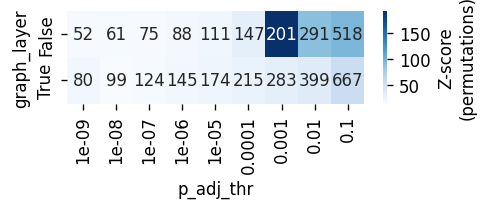

In [93]:
rcParams['figure.figsize'] = 4, 1
rcParams['figure.dpi'] = 120
hm = table.pivot(index='graph_layer', columns='p_adj_thr', values='n_pos').fillna(0)
z = table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore').fillna(0)
sns.heatmap(z, annot=hm, fmt='', cmap='Blues', # vmin=0, vmax=5,
            cbar_kws={'label': 'Z-score\n(permutations)'})

In [94]:
genes_by_module_name = (
    res.groupby(["module_name"])["gene_name"].apply(lambda grp: list(grp.value_counts().index)).to_dict()

)
# genes_by_module_name

In [95]:
res.sort_values("p_adj")

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
2097         51             True            52    Dbpht2     True -0.262511   
3856        280             True           281      Pax6     True -0.253239   
3653        247             True           248       Arx     True -0.219048   
1996         31             True            32      Rora     True -0.214814   
1458         97            False            98       Fev     True -0.203059   
...         ...              ...           ...       ...      ...       ...   
2688         69             True            70      Ttc5     True -0.000042   
1852        247            False           248  Arhgef18     True -0.000026   
1167         69            False            70      Taf5     True -0.000024   
2617         69             True            70    Tubb4b     True -0.000014   
3651        247             True           248     Armh4     True -0.000018   

             p_val module_name         p_adj  
2097  2.456352e-66  CCAAT/CEBP  9.481520e-63  
3856  1.041645e-61       PAX/1  2.010375e-58  
3653  3.033307e-46       NR/20  3.902855e-43  
1996  1.682186e-44        NR/3  1.623309e-41  
1458  7.485827e-40       ETS/1  5.779059e-37  
...            ...         ...           ...  
2688  9.978247e-01       TBX/1  9.989675e-01  
1852  9.986724e-01       NR/20  9.992753e-01  
1167  9.987576e-01       TBX/1  9.992753e-01  
2617  9.992759e-01       TBX/1  9.992759e-01  
3651  9.990890e-01       NR/20  9.992759e-01  

[3860 rows x 9 columns]

In [96]:
res["k"] = res["gene_name"] + "_" + res["archetype_id"].astype(str)
df2 = res.pivot(index="k", columns="opt_log_dynamic", values="spearman")
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [97]:
df2

opt_log_dynamic     False     True 
k                                  
Ahr_284          0.001563  0.016311
Aire_139         0.049021  0.010893
Ap2a1_264       -0.045952 -0.091285
Ap2a2_264       -0.017137 -0.025143
Ap2b1_264       -0.063917 -0.084852
...                   ...       ...
Zfp820_121       0.026777  0.039429
Zfp821_121      -0.011098 -0.001884
Zfp825_121       0.029319  0.022503
Zfp827_121      -0.056902 -0.020865
Zfx_144          0.020012  0.021238

[1930 rows x 2 columns]

In [98]:
mb.pl.set_rcParams({"figure.figsize": [5, 4], "figure.dpi": 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)

In [99]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

In [100]:
# res['arch_name'] = name_by_filter_id

In [101]:
res

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
0             1            False             2    Arid3b     True  0.013050   
1             1            False             2      Pax4     True  0.062621   
2             1            False             2     Shox2     True  0.010643   
3             1            False             2    Nkx6-2     True -0.038003   
4             1            False             2      Pdx1     True  0.031583   
...         ...              ...           ...       ...      ...       ...   
3855        280             True           281   Pax6os1     True -0.161616   
3856        280             True           281      Pax6     True -0.253239   
3857        282             True           283      Pax2     True  0.010454   
3858        283             True           284       Ahr     True  0.016311   
3859        284             True           285      Klf8     True -0.001669   

             p_val   module_name         p_adj            k  
0     4.007533e-01          HD/2  5.995767e-01     Arid3b_2  
1     5.440803e-05          HD/2  4.794863e-04       Pax4_2  
2     4.931764e-01          HD/2  6.833896e-01      Shox2_2  
3     1.437560e-02          HD/2  5.521377e-02     Nkx6-2_2  
4     4.195094e-02          HD/2  1.264096e-01       Pdx1_2  
...            ...           ...           ...          ...  
3855  1.129311e-25         PAX/1  1.895278e-23  Pax6os1_281  
3856  1.041645e-61         PAX/1  2.010375e-58     Pax6_281  
3857  5.008692e-01  PAX-halfsite  6.912246e-01     Pax2_283  
3858  2.935866e-01           AHR  4.872074e-01      Ahr_284  
3859  9.143989e-01      KLF/SP/3  9.555085e-01     Klf8_285  

[3860 rows x 10 columns]

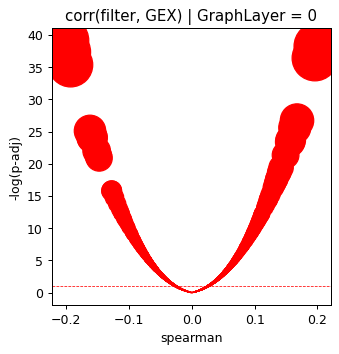

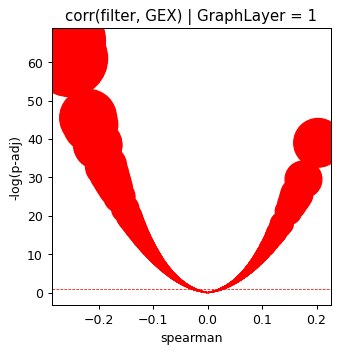

In [102]:
rcParams["figure.figsize"] = 4, 4
rcParams["figure.dpi"] = 90

for optimize_log_dynamic, grp in res.groupby("opt_log_dynamic"):
    grp["minus_log10_pval"] = -np.log10(grp["p_val"])
    grp = grp.sort_values("matched")
    plt.scatter(
        grp["spearman"],
        grp["minus_log10_pval"],
        s=np.power(grp["minus_log10_pval"], 2),
        color=np.where(grp["matched"], "red", "blue"),
    )
    plt.ylabel("-log(p-adj)")
    plt.xlabel("spearman")
    plt.title("corr(filter, GEX) | GraphLayer = %i" % optimize_log_dynamic)
    plt.axhline(1, ls="--", color="red", lw=0.6)
    plt.show()

In [103]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

Text(0, 0.5, '# associations')

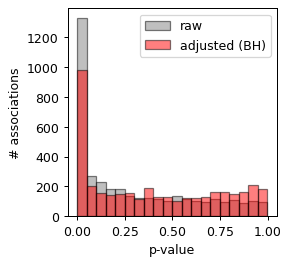

In [104]:
rcParams["figure.figsize"] = 3, 3
rcParams["figure.dpi"] = 90
plt.hist(res["p_val"], color="gray", bins=20, label="raw", alpha=0.5, edgecolor="black")
plt.hist(res["p_adj"], color="red", bins=20, label="adjusted (BH)", alpha=0.5, edgecolor="black")
plt.xlabel("p-value")
plt.legend()
plt.ylabel("# associations")

In [105]:
res[res["p_adj"] < 0.05]

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
1             1            False             2      Pax4     True  0.062621   
10            1            False             2    Nkx6-1     True  0.077742   
17            7            False             8       Arx     True -0.068667   
25           11            False            12      Pbx1     True  0.045143   
33           13            False            14   Onecut1     True -0.047445   
...         ...              ...           ...       ...      ...       ...   
3846        263             True           264     Ap2b1     True -0.084852   
3847        264             True           265      Ctcf     True  0.076174   
3848        265             True           266     Insm1     True  0.065165   
3855        280             True           281   Pax6os1     True -0.161616   
3856        280             True           281      Pax6     True -0.253239   

             p_val module_name         p_adj            k  
1     5.440803e-05        HD/2  4.794863e-04       Pax4_2  
10    5.356512e-07        HD/2  7.464309e-06     Nkx6-1_2  
17    9.583438e-06        HD/8  1.016266e-04        Arx_8  
25    3.636877e-03       HD/12  1.816086e-02      Pbx1_12  
33    2.239182e-03       CUX/1  1.197125e-02   Onecut1_14  
...            ...         ...           ...          ...  
3846  4.422229e-08     TFAP2/1  7.519737e-07    Ap2b1_264  
3847  9.030204e-07        CTCF  1.201951e-05     Ctcf_265  
3848  2.667635e-05       INSM1  2.542487e-04    Insm1_266  
3855  1.129311e-25       PAX/1  1.895278e-23  Pax6os1_281  
3856  1.041645e-61       PAX/1  2.010375e-58     Pax6_281  

[982 rows x 10 columns]

In [106]:
pval_thr = 1e-5
sel_genes = set(list(res[res["p_adj"] < pval_thr]["gene_name"]))

In [107]:
log_act = ad.obsm["log_activities"].copy()

In [108]:
cols_act = ["intercept", "dinuc_bias"] + [name_by_filter_id[k] for k in log_act.columns[2:]]
log_act.columns = cols_act

In [109]:
import anndata


ad_act = anndata.AnnData(log_act)

ad_act.obsm["X_umap"] = ad.obsm["X_umap"]

ad_act.obs = ad.obs

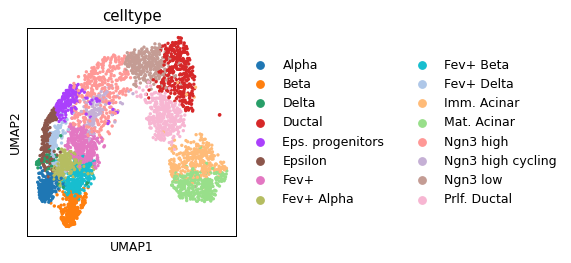

In [110]:
sc.pl.umap(ad_act, color="celltype")

Rank genes groups using the annotation

In [111]:
sc.tl.rank_genes_groups(ad_act, "celltype")
rkg_df = []
for ct in ad_act.obs["celltype"].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2["celltype"] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df["module_name"] = rkg_df["names"].map(anno.set_index("Cluster_ID")["Name"].to_dict())
rkg_df["module_name"] = np.where(~pd.isnull(rkg_df["module_name"]), rkg_df["module_name"], rkg_df["names"])
rkg_df.head()

Eps. progenitors
Imm. Acinar
Alpha
Ngn3 high
Prlf. Ductal
Epsilon
Fev+
Ngn3 low
Fev+ Alpha
Fev+ Delta
Ngn3 high cycling
Beta
Ductal
Fev+ Beta
Delta
Mat. Acinar


names    scores  logfoldchanges         pvals     pvals_adj  \
0       SIX/1  5.979688             NaN  3.360914e-09  3.024823e-08   
1     SPDEF/1  5.624515             NaN  3.646747e-08  3.000752e-07   
2         GLI  5.513223             NaN  8.842945e-08  6.883157e-07   
3      NFAT/1  5.450161             NaN  7.894709e-08  6.315767e-07   
4  EVI1/MECOM  5.347757             NaN  2.010762e-07  1.447749e-06   

           celltype module_name  
0  Eps. progenitors       SIX/1  
1  Eps. progenitors     SPDEF/1  
2  Eps. progenitors         GLI  
3  Eps. progenitors      NFAT/1  
4  Eps. progenitors  EVI1/MECOM

Get top modules

In [112]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index("names")["module_name"].to_dict())

In [113]:
sc.tl.rank_genes_groups(ad_act, "celltype")

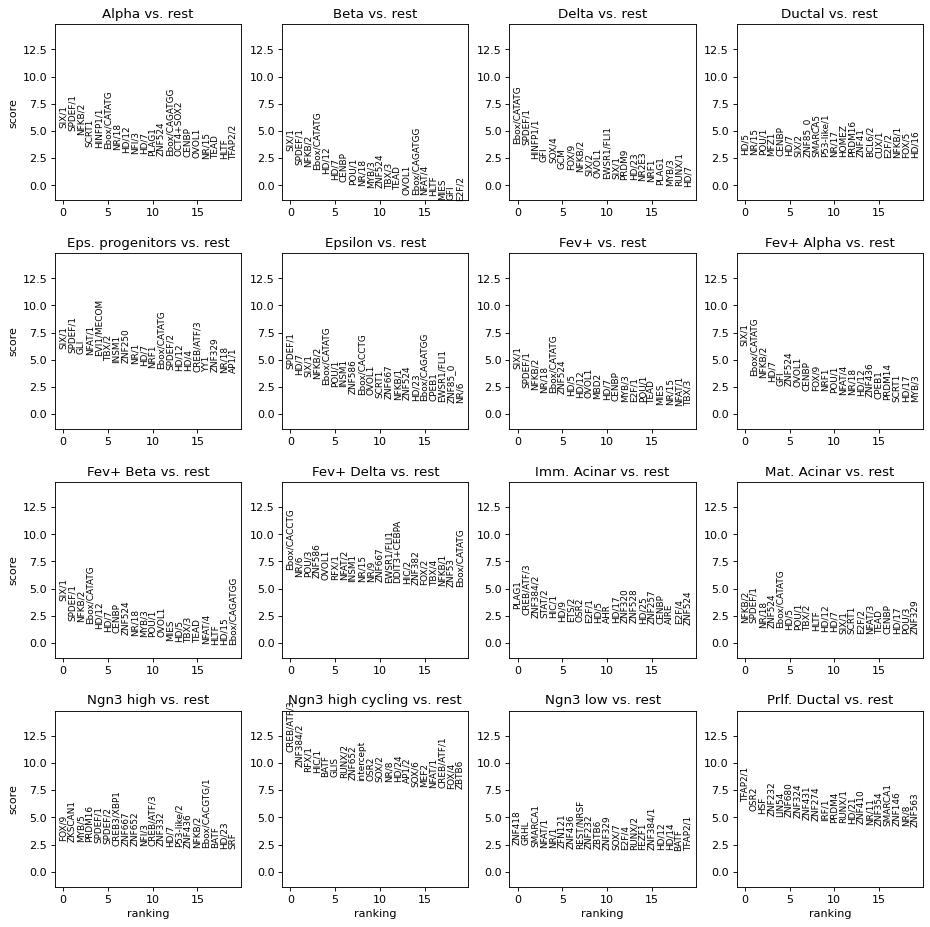

In [114]:
rcParams["figure.figsize"] = 3.5, 3.5
rcParams["figure.dpi"] = 80
sc.pl.rank_genes_groups(ad_act)

In [115]:
set(res[(res["p_adj"] < 1e-5)]["k"])

{'Ap2a1_264',
 'Ap2b1_264',
 'Araf_248',
 'Arc_248',
 'Arf1_248',
 'Arf3_248',
 'Arf5_248',
 'Arfgef1_248',
 'Arfgef3_248',
 'Arg1_248',
 'Arhgap11a_248',
 'Arhgap18_248',
 'Arhgap19_248',
 'Arhgap21_248',
 'Arhgap24_248',
 'Arhgap26_248',
 'Arhgap28_248',
 'Arhgap36_248',
 'Arhgap42_248',
 'Arhgap6_248',
 'Arhgef10l_248',
 'Arhgef11_248',
 'Arhgef12_248',
 'Arhgef19_248',
 'Arhgef26_248',
 'Arhgef39_248',
 'Arhgef5_248',
 'Arhgef9_248',
 'Arid1b_248',
 'Arid4b_248',
 'Arih1_248',
 'Arl3_248',
 'Arl4a_248',
 'Arl4c_248',
 'Arl6ip1_248',
 'Arl6ip4_248',
 'Arl8a_248',
 'Armc4_248',
 'Armc8_248',
 'Armc9_248',
 'Armh3_248',
 'Arpc5_248',
 'Arpp19_248',
 'Arx_248',
 'Atf7ip_50',
 'Bhlha15_62',
 'Creb3l2_50',
 'Dbpht2_52',
 'E2f7_157',
 'E2f8_157',
 'Ebf1_174',
 'Ehf_96',
 'Ehf_98',
 'Elf4_98',
 'Elf5_96',
 'Ets1_96',
 'Ets1_98',
 'Etv1_98',
 'Etv6_96',
 'Etv6_98',
 'Fev_96',
 'Fev_98',
 'Fos_49',
 'Fosb_49',
 'Fosb_54',
 'Foxa3_79',
 'Foxm1_79',
 'Foxo1_164',
 'Foxo1_77',
 'Foxo1_79',
 'Fo

In [116]:
res[res["module_name"].str.contains("HD")].sort_values("p_adj")

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman  \
10            1            False             2    Nkx6-1     True  0.077742   
1685        203            False           204      Irx2     True -0.073541   
1937          1             True             2      Isl1     True -0.071139   
1935          1             True             2     Lmx1b     True  0.070839   
17            7            False             8       Arx     True -0.068667   
...         ...              ...           ...       ...      ...       ...   
3619        209             True           210    Hmbox1     True  0.001564   
3615        203             True           204      Irx2     True  0.001463   
1689        209            False           210    Hmbox1     True -0.001186   
1941          1             True             2      Gbx1     True -0.000674   
16            1            False             2    Pou6f2     True -0.000217   

             p_val module_name     p_adj           k  
10    5.356512e-07        HD/2  0.000007    Nkx6-1_2  
1685  2.122596e-06       HD/23  0.000026    Irx2_204  
1937  4.515096e-06        HD/2  0.000052      Isl1_2  
1935  4.953960e-06        HD/2  0.000056     Lmx1b_2  
17    9.583438e-06        HD/8  0.000102       Arx_8  
...            ...         ...       ...         ...  
3619  9.198000e-01       HD/25  0.957518  Hmbox1_210  
3615  9.249364e-01       HD/23  0.961814    Irx2_204  
1689  9.391570e-01       HD/25  0.969940  Hmbox1_210  
1941  9.653987e-01        HD/2  0.982135      Gbx1_2  
16    9.888425e-01        HD/2  0.995317    Pou6f2_2  

[68 rows x 10 columns]

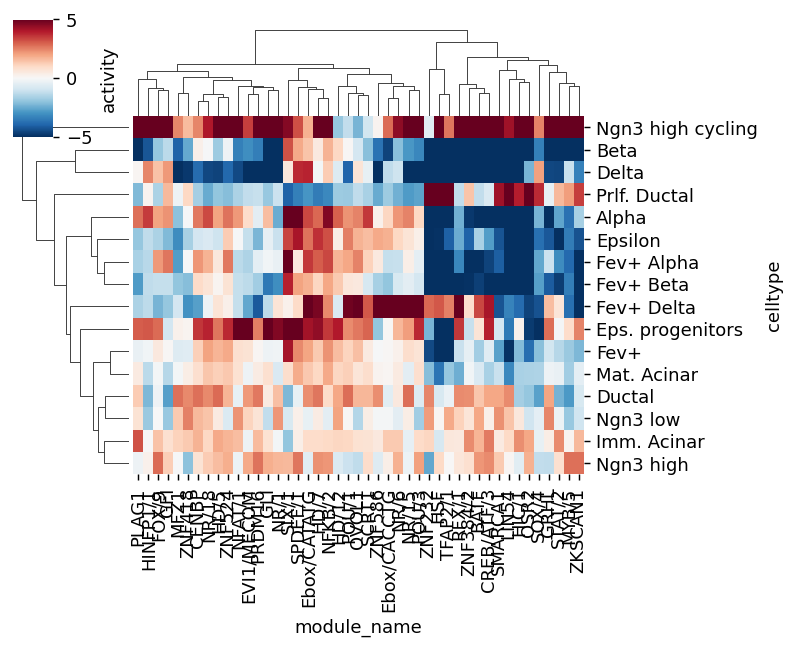

In [117]:
mod_names_best = set(rkg_df.sort_values("scores", ascending=False).groupby("celltype").head(5)["module_name"])
best = rkg_df[rkg_df["module_name"].isin(mod_names_best)]
rcParams["figure.dpi"] = 130
sns.clustermap(
    best.pivot(index="celltype", columns="module_name", values="scores"),
    cbar_kws={"label": "activity"},
    cmap="RdBu_r",
    vmin=-5,
    vmax=5,
    figsize=[6.2, 5],
    # dpi=100,
    xticklabels=True,
)

In [118]:
rna_tfs = rna_sel.to_df()[list(set(res["gene_name"]))]
rna_tfs["celltype"] = rna_sel.obs["celltype"]
mean_tfs = rna_tfs.groupby("celltype").mean()

act_tfs_df = ad_act.to_df()
act_tfs_df["celltype"] = ad_act.obs["celltype"]
mean_act_tf = act_tfs_df.groupby("celltype").mean()

In [119]:
corr_celltype = []
for i, c1 in enumerate(mean_act_tf):
    if i % 50 == 0:
        print(i, mean_act_tf.shape[1])
    for j, c2 in enumerate(mean_tfs):
        if not c1 in genes_by_module_name or not c2 in genes_by_module_name[c1]:
            continue
        a = mean_act_tf[c1]
        b = mean_tfs[c2]
        corr_celltype.append([c1, c2, mean_act_tf.index[np.argmax(mean_act_tf[c1])]] + list(pearsonr(a, b)))

corr = pd.DataFrame(corr_celltype, columns=["module_name", "gene_name", "cell_type", "pearsonr", "p_val"])
corr = corr.sort_values("pearsonr", ascending=False)

0 288
50 288
100 288
150 288
200 288
250 288


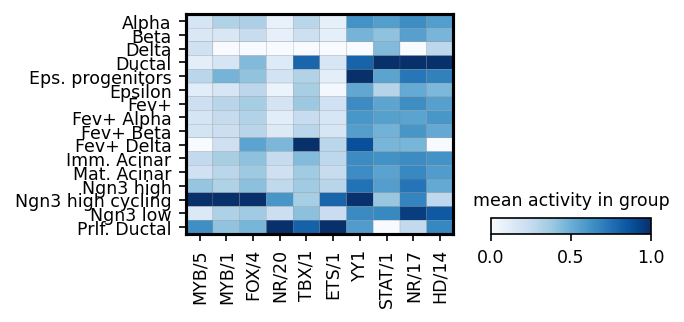

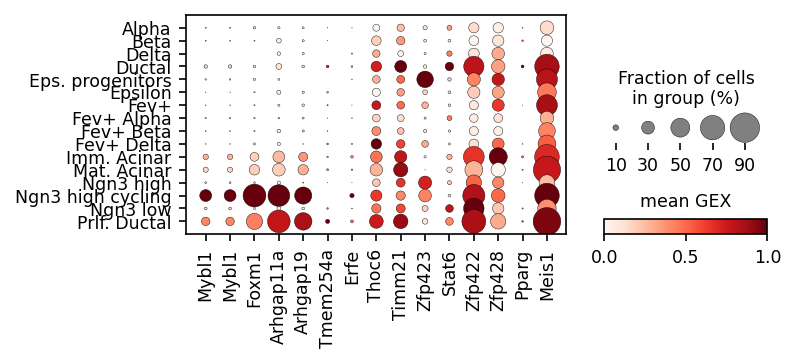

In [120]:
rcParams['figure.dpi'] = 150
# activators
module_names = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.9],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              standard_scale='var',
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.9])



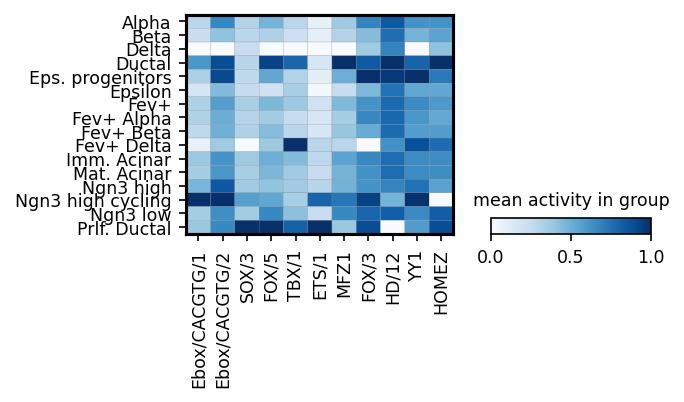

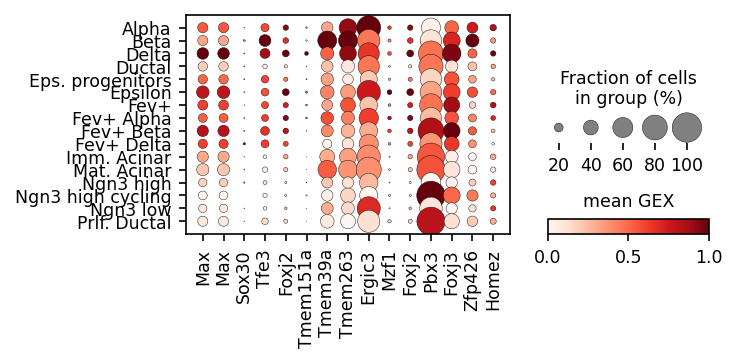

In [121]:
# repressors
module_names = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.9],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              standard_scale='var',
              var_names=gene_names,
              figsize=[4.5, 1.9])



In [122]:
# sc.pl.dotplot(rna_sel, groupby='celltype', var_names=list(set(res['gene_name'])))

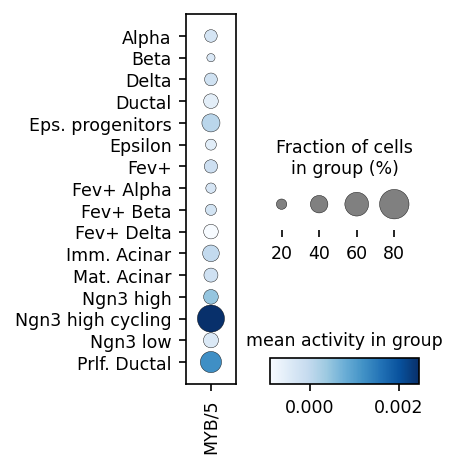

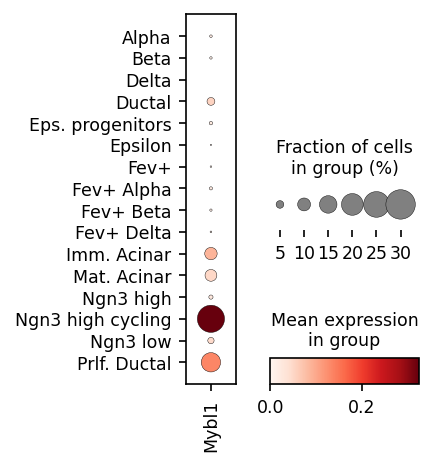

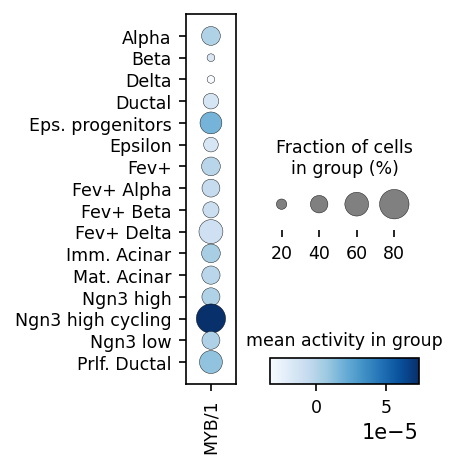

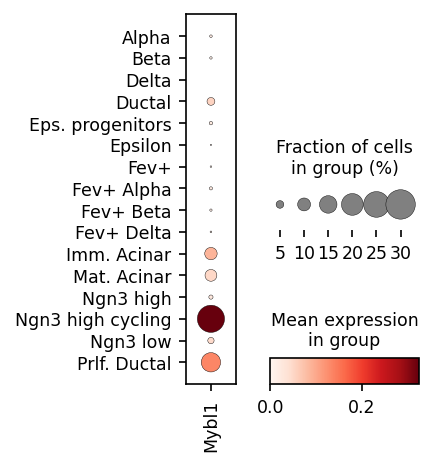

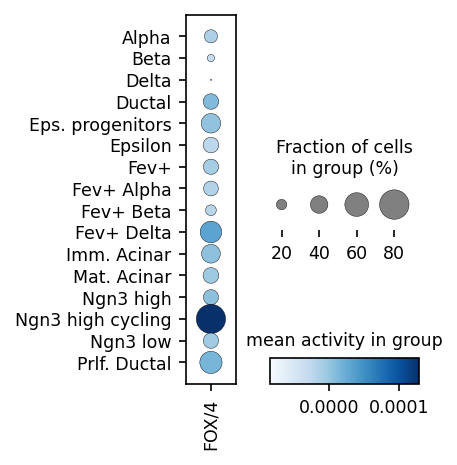

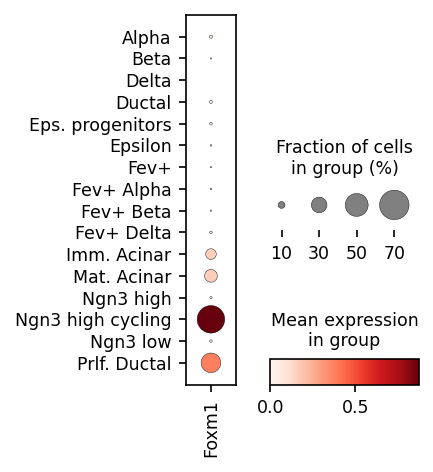

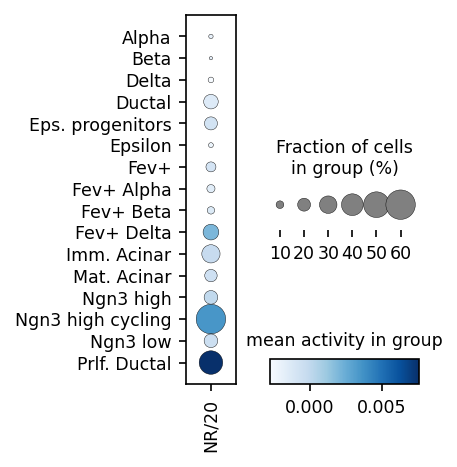

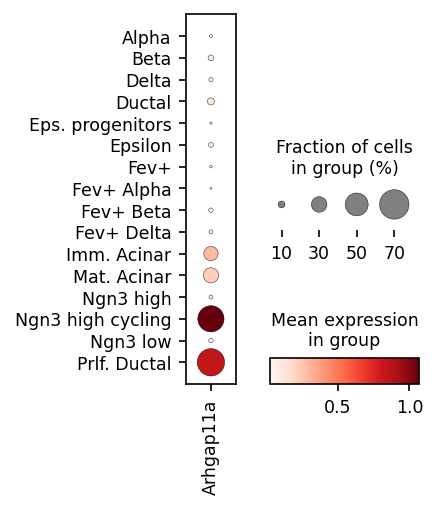

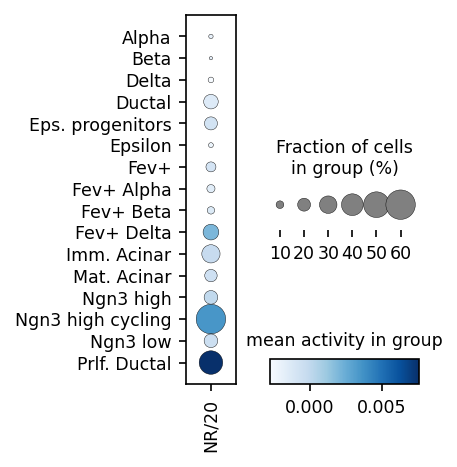

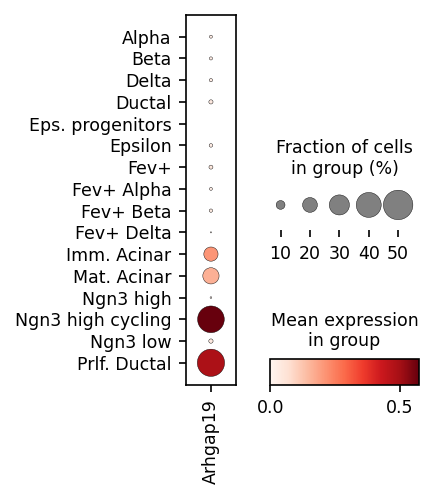

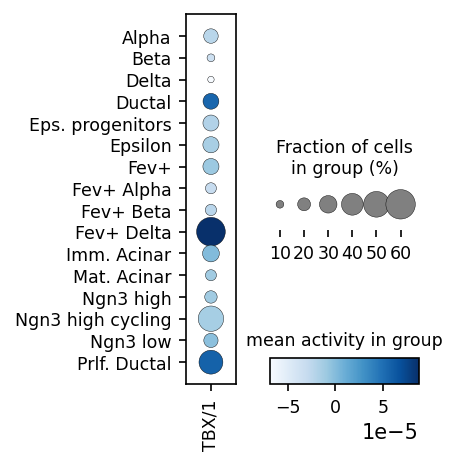

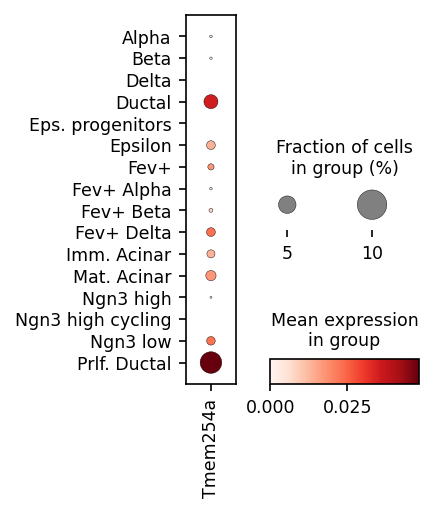

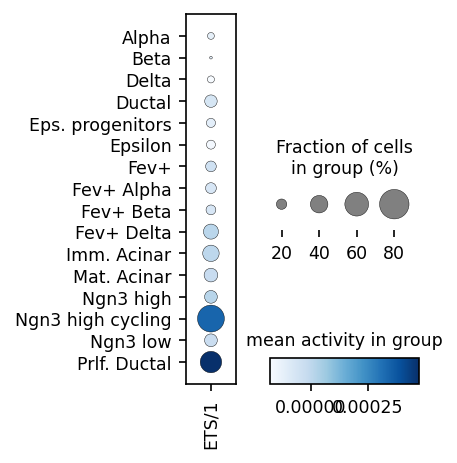

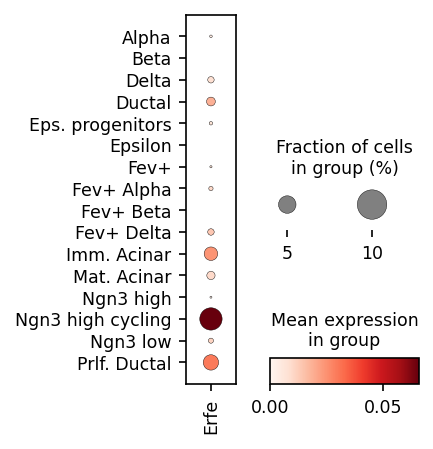

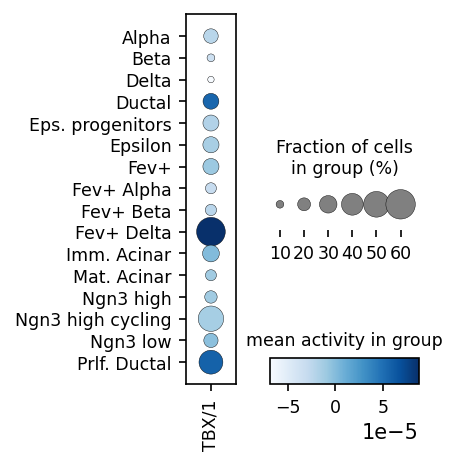

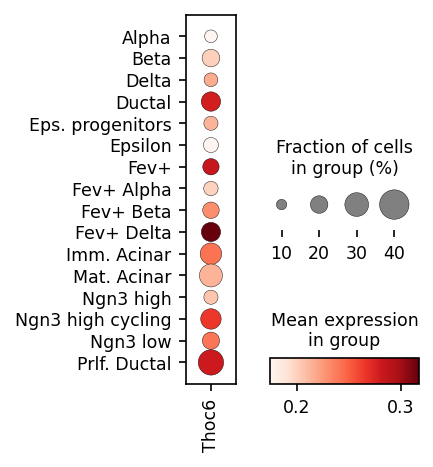

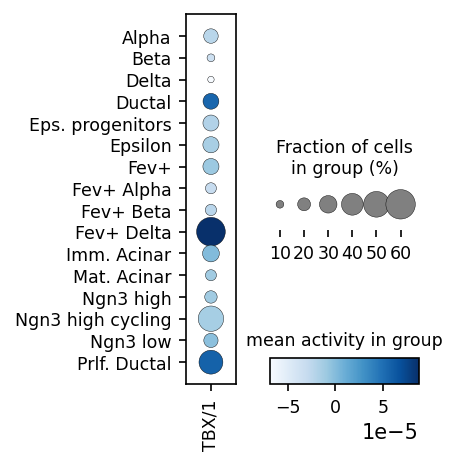

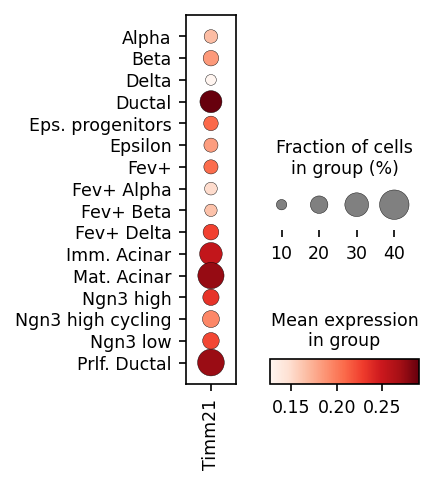

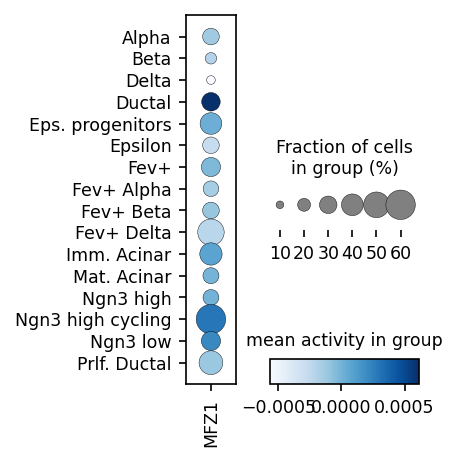

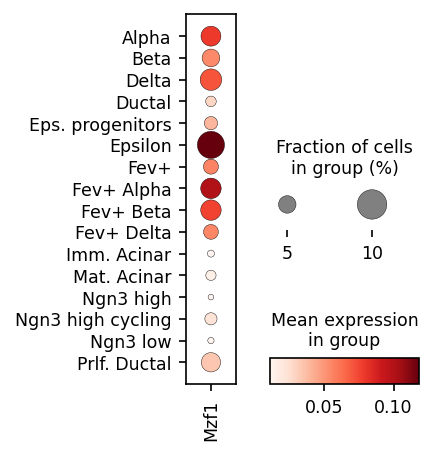

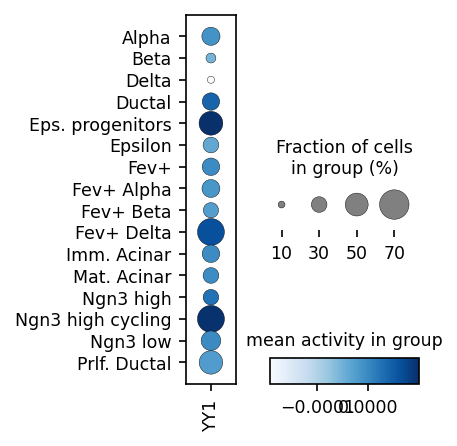

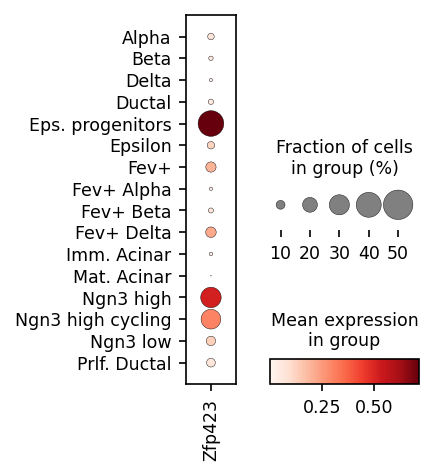

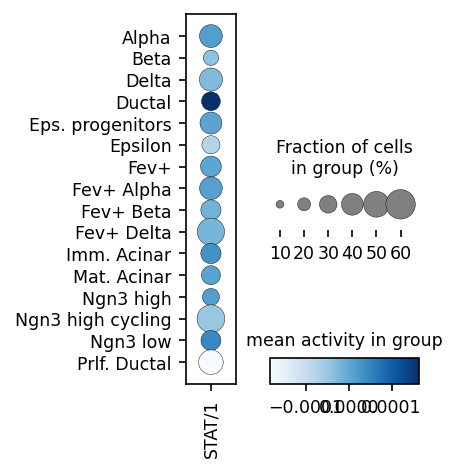

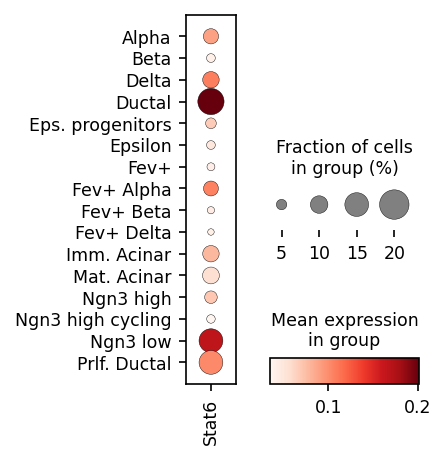

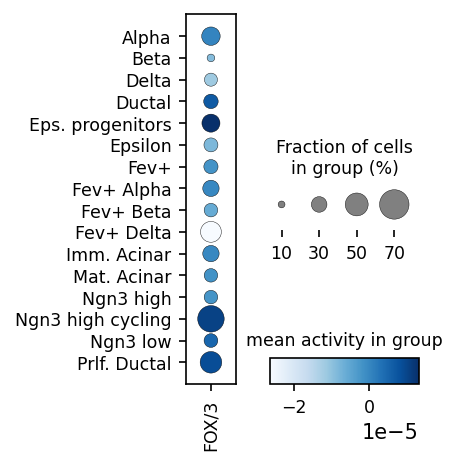

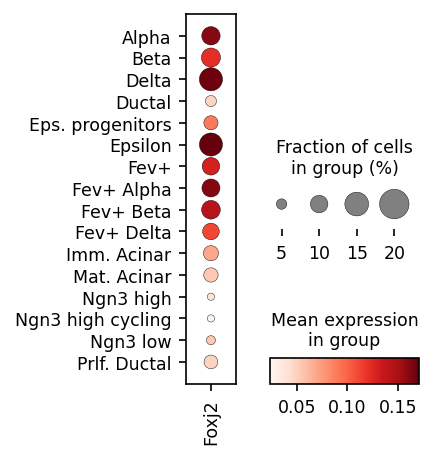

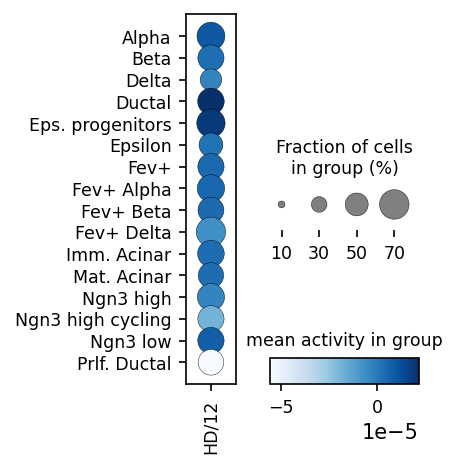

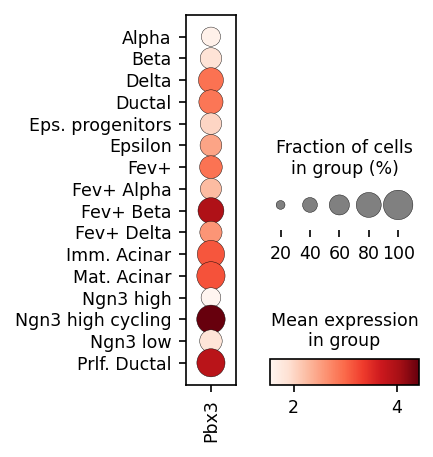

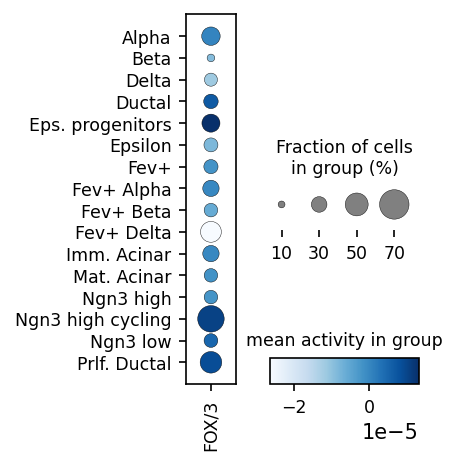

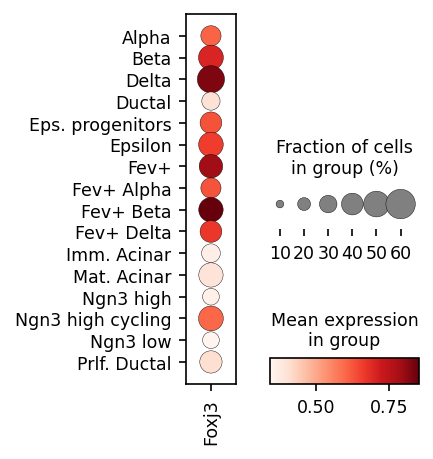

In [123]:
for ri, r in corr.sort_values("p_val").groupby("cell_type").head(3).iterrows():
    # ad_act.obs['HD/2'] = log_act['HD/2']
    sc.pl.dotplot(
        ad_act,
        groupby="celltype",
        cmap="Blues",
        var_names=r["module_name"],
        figsize=[2, 3.2],
        colorbar_title="mean activity in group",
    )
    sc.pl.dotplot(rna_sel, groupby="celltype", var_names=r["gene_name"], figsize=[2, 3.2])

## Filter activities versus graph activities

In [124]:
A = model.get_log_activities()
sum_A = A.abs().sum(axis=1).cpu().detach().numpy()
A = A.squeeze(0)
print(A.shape)

torch.Size([288, 4148])


In [125]:
# this function assesses the contributions of A on the graph
indices, contributions, max_eig = mb.tl.compute_contributions(A, C * D)

contributions_normalized = torch.abs(contributions) / max_eig
contributions_df = pd.DataFrame(contributions_normalized.detach(), columns=["index"])
print("Summary statistics of the normalized contributions: \n")
contributions_df.describe()

Summary statistics of the normalized contributions: 



index
count  288.000000
mean     0.300399
std      0.049388
min      0.149585
25%      0.270559
50%      0.299396
75%      0.329398
max      0.513186

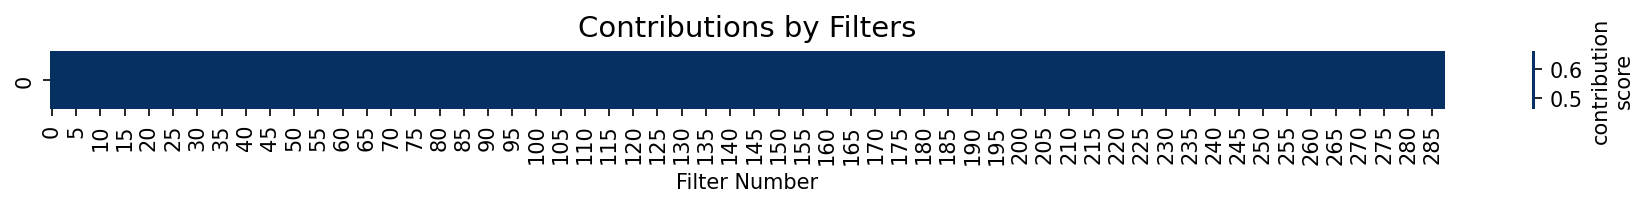

In [126]:
mb.pl.filter_contrib_heatmap(contributions_normalized)

Percentage of non-zero entries of the filter matrix A: 100.0 %
(288,) (288,)


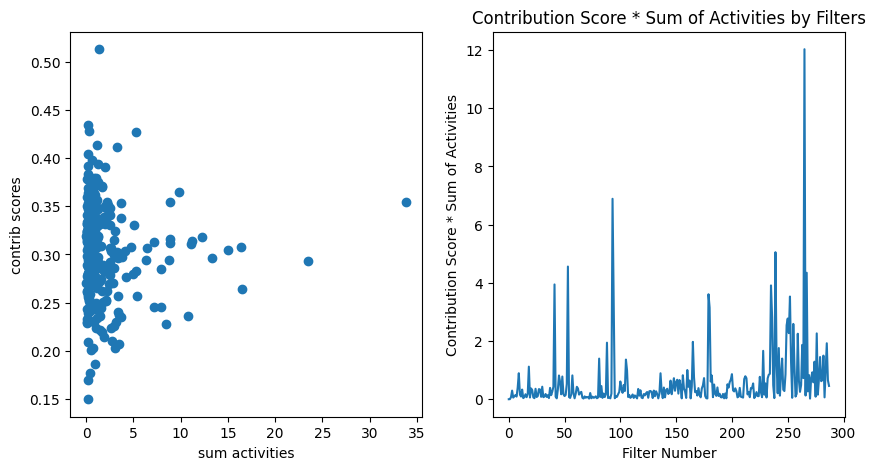

In [127]:
from matplotlib.pyplot import rcParams

rcParams["figure.dpi"] = 100
plt.figure(figsize=(10, 5))

print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")

mb.pl.filter_contrib_simple(contributions_normalized, A.cpu())

In [128]:
# normalize the data, and look at summary stats
sum_A_norm = sum_A / np.max(sum_A)
sum_A_df = pd.DataFrame(sum_A.T, columns=["sum_A"])
sum_A_df.describe()

sum_A
count  4148.000000
mean      0.134161
std       0.509002
min       0.006000
25%       0.031845
50%       0.059126
75%       0.106652
max      19.711349

In [129]:
contrib_arr = contributions_normalized.unsqueeze(dim=0).detach().numpy()
sum_A = A.cpu().abs().sum(axis=1).detach().numpy()
contrib = contrib_arr[0]

contrib_times_activities = contrib * sum_A
contrib_times_activities_norm = contrib_times_activities / np.max(contrib_times_activities)
contrib_times_activities_df = pd.DataFrame(contrib_times_activities, columns=["contribution_times_activities"])
contrib_times_activities_df.describe()

contribution_times_activities
count                     288.000000
mean                        0.580848
std                         1.114942
min                         0.000039
25%                         0.084503
50%                         0.244805
75%                         0.607406
max                        12.027171

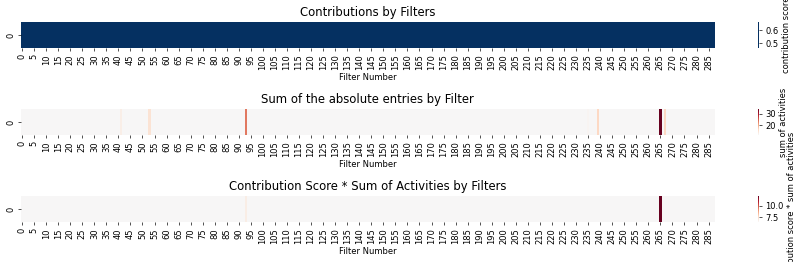

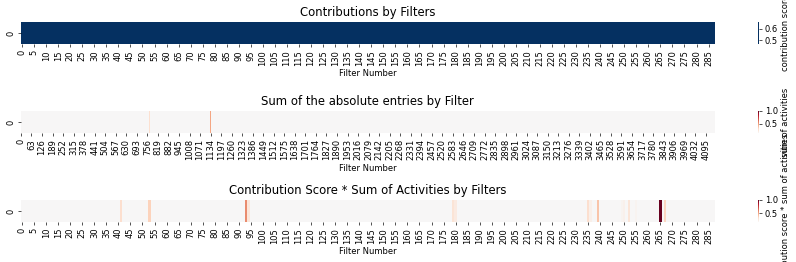

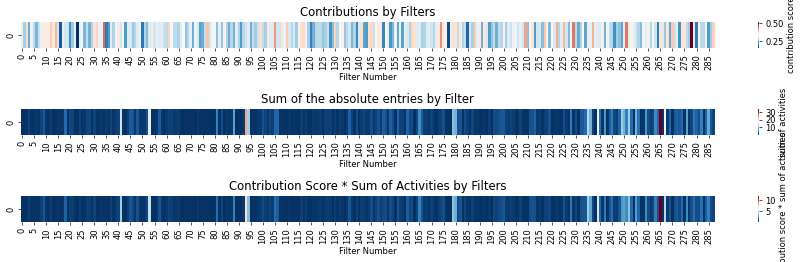

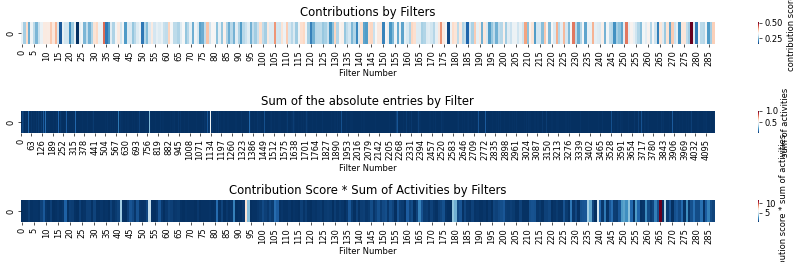

In [130]:
from matplotlib.pyplot import rcParams

rcParams["figure.dpi"] = 60

# unsqueeze the data to make it compatible with the heatmap function
sum_A_norm = sum_A_norm.reshape(1, -1)
contrib_times_activities = contrib_times_activities.reshape(1, -1)


# only plotting filters, that are within the top 25% of the maximum contribution score
mb.pl.contrib_heatmaps(
    contributions_normalized, sum_A.reshape(1, -1), contrib_times_activities, (0.66, 11.85, 6.49), (0.66, 11.85, 6.49)
)  # vmin values come from the describe() functions

# plotting top 25% of filters normalized
mb.pl.contrib_heatmaps(
    contributions_normalized,
    sum_A_norm,
    contrib_times_activities_norm.reshape(1, -1),
    vmins=(0.66, 0.14, 0.19),
    centers=(0.66, 0.14, 0.19),
)  # vmin values come from the describe() functions

# plotting all filter
mb.pl.contrib_heatmaps(contributions_normalized, sum_A.reshape(1, -1), contrib_times_activities)

# plotting all filters normalized
mb.pl.contrib_heatmaps(contributions_normalized, sum_A_norm, contrib_times_activities)

In [131]:
anno[anno['Name'] == 'TFAP2/1']

Cluster_ID     Name   DBD            Seed_motif  Total_width  \
215         264  TFAP2/1  TFAP  AP2A_HUMAN.H11MO.0.A           15   

     Consensus_left  Consensus_right  Cluster_size Name_unique  
215               3               12            24     TFAP2/1

CCAAT/CEBP:Dbpht2 (0.1720937640006659, -0.25065593775891365) 0.13389064371585846
TFAP2/1:Ap2a1 (0.16934142280417683, -0.08402084705306512) 0.1476256102323532
SOX/3:Sox9 (0.15753252147244204, 0.18560171158579572) 0.1220342144370079
NR/11:Nr5a2 (0.14898926350945468, 0.16772229119035836) 0.22390590608119965
INSM1:Insm1 (0.07528510790631371, 0.10708151559982063) 0.1544010490179062
NR/20:Arx (0.06796238047242101, -0.20645490702615268) 0.09940777719020844
SOX/4:Sox9 (0.05500507330156641, 0.13810009446234975) 0.10138282924890518
PAX/1:Pax6 (0.05140092184186695, -0.2423623002558698) 0.1068013533949852
RUNX/1:Runx1t1 (0.05045390085464, -0.1114396013380605) 0.10600508749485016
PROX1:Prox1 (0.04831346541873673, 0.054757961846733594) 0.16807278990745544


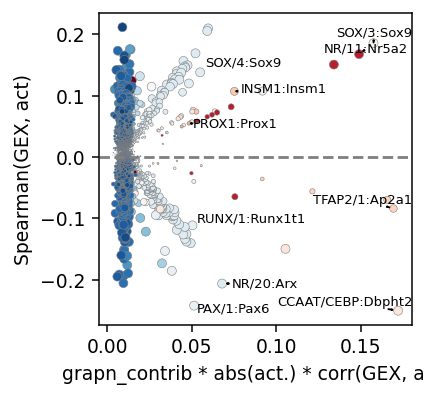

In [159]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 135
rcParams['pdf.fonttype'] = 42
from adjustText import adjust_text

def delta_models(model_by_logdynamic):
    model = model_by_logdynamic[True]
    log_act1 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act1 = pd.DataFrame(log_act1.detach().cpu().numpy())

    model = model_by_logdynamic[False]
    log_act2 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act2 = pd.DataFrame(log_act2.detach().cpu().numpy())

    d = log_act1.mean(axis=0) - log_act2.mean(axis=0)
    # d.index = ad.obs_names
    return d

# graph = True - graph = False
delta_model = delta_models(model_by_logdynamic)
delta_model
delta_model = delta_model[2:]
delta_model.index = range(len(delta_model))
delta_model.index += 1
delta_model.index = delta_model.index.map(name_by_filter_id)
delta_model

res['act_change'] = res['module_name'].map(delta_model.to_dict())
res['k'] = res['module_name'] + ':' + res['gene_name']
res['graph_score'] = res['filter_id'].map({i : contrib_times_activities[0][i + 2] for i in range(len(contrib_times_activities[0]) - 2)})
res['z'] = np.sqrt((res['graph_score'] ** 2) * (-np.log(res['p_adj'] + 1e-10)) ** 2)


ax = plt.subplot()
cmap = sns.color_palette('RdBu_r', as_cmap=True)

res_sel = res.sort_values('z', ascending=False)
res_sel = res_sel.sort_values('z', ascending=False) # .drop_duplicates('module_name')
# res_sel = res_sel.drop_duplicates('module_name')

# res_sel['x'] = np.log((res_sel['graph_score'] + 1) * (res_sel['act_change'].abs() + 1))
res_sel['x'] = res_sel['graph_score'] * res_sel['act_change'].abs() * res_sel['spearman'].abs()
# res_sel['x'] = res_sel['act_change'].abs() * res_sel['spearman'].abs()

# general noise stacking of cells on x-y axes
sigma = 0.002
mu =0.01
# generate normally distributed samples
noise = sigma * np.random.randn(res_sel.shape[0]) + mu
res_sel['x'] = res_sel['x'] + noise
res_sel['spearman'] = res_sel['spearman'] + noise


plt.scatter(res_sel['x'],            
            res_sel['spearman'],
            s=-np.log(res_sel['p_adj'] + 1e-10),
            cmap=cmap,
            lw=.3,
            edgecolors='gray',
            c=res_sel['act_change'])
plt.axhline(y=0, ls='--', c='gray')
plt.xlabel('grapn_contrib * abs(act.) * corr(GEX, act)')
plt.ylabel('Spearman(GEX, act)')


res_sel = res_sel.sort_values('x', ascending=False).drop_duplicates('module_name')
texts = [] # [plt.text(x[i], y[i], 'Text%s' %i, ha='center', va='center') for i in range(len(x))]

for ri, r in res_sel.head(10).iterrows():
    print(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), r['act_change'])
    t = ax.annotate(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), fontsize=7)
    texts.append(t)
adjust_text(texts, arrowprops=dict(arrowstyle='->'))

plt.savefig('../../../output/graph_contribution_pancreatic_endocrinogesis.pdf')
plt.show()

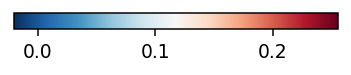

In [160]:
import pylab as pl
import numpy as np

a = np.array([[res_sel['act_change'].min(), res_sel['act_change'].max()]])
pl.figure(figsize=(3, .2))
img = pl.imshow(a, cmap="RdBu_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
pl.savefig("../../../output/graph_contribution_pancreatic_endocrinogenesis_cbar.pdf")

In [133]:
scv.tl.velocity_pseudotime(rna)
# scv.pl.scatter(rna, color="velocity_pseudotime", color_map="gnuplot")

computing terminal states
    identified 9 regions of root cells and 1 region of end points .
    finished (0:00:08) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [137]:
def running_mean(y_in, x_in, N_out=101, sigma=.05):
    '''
    Returns running mean as a Bell-curve weighted average at evenly spaced
    points. Does NOT wrap signal around, or pad with zeros.
    
    Arguments:
    y_in -- y values, the values to be smoothed and re-sampled
    x_in -- x values for array
    
    Keyword arguments:
    N_out -- NoOf elements in resampled array.
    sigma -- 'Width' of Bell-curve in units of param x .
    '''
    import numpy as np
    N_in = len(y_in)

    # Gaussian kernel
    x_out = np.linspace(np.min(x_in), np.max(x_in), N_out)
    x_in_mesh, x_out_mesh = np.meshgrid(x_in, x_out)
    gauss_kernel = np.exp(-np.square(x_in_mesh - x_out_mesh) / (2 * sigma**2))
    # Normalize kernel, such that the sum is one along axis 1
    normalization = np.tile(np.reshape(np.sum(gauss_kernel, axis=1), (N_out, 1)), (1, N_in))
    gauss_kernel_normalized = gauss_kernel / normalization
    # Perform running average as a linear operation
    y_out = gauss_kernel_normalized @ y_in

    return y_out, x_out

In [138]:
# prepare velocity pseudotime values for visualization
atac.obs['velocity_pseudotime'] = rna.obs['velocity_pseudotime'].values
ad.obs['velocity_pseudotime'] = atac.obs['velocity_pseudotime']

### Given a few potential genes, verify its association with chromatin targets

In [139]:
def plot_pseudotime(gene_name, filter_name, sigma_gex=.05, sigma_filter=.1):
    rcParams['figure.figsize'] = 3, 2
    gene_key = gene_name
    x = rna.obs['velocity_pseudotime']
    y = rna[:,rna.var_names==gene_key].X.A.flatten()
    y = np.log(y)
    y[y == -np.inf] = np.nanmin(y[y != -np.inf])

    y_mean, x_mean = running_mean(y, x, sigma=sigma_gex)
    plt.scatter(x, y, edgecolors=None, color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='green')
    plt.ylabel('')
    plt.title(gene_key)
    plt.ylabel('gene expression [log]')
    plt.xlabel('pseudotime')


    x = ad.obs['velocity_pseudotime']

    plt.show()
    filter_id = int(res[res['module_name'].str.contains(filter_name)]['filter_id'].values[0])

    y= act.T.numpy()[:,filter_id]
    # y = np.abs(y)
    # y = np.log(y)
    # y[y == -np.inf] = np.nanmin(y[y != -np.inf])

    y_mean, x_mean = running_mean(y, x, sigma=sigma_filter)
    # plt.scatter(x, y, edgecolors='black', color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='red')
    plt.ylabel('')
    plt.title('filter activities %s' % filter_name)
    plt.ylabel('filter activity')
    plt.xlabel('pseudotime')


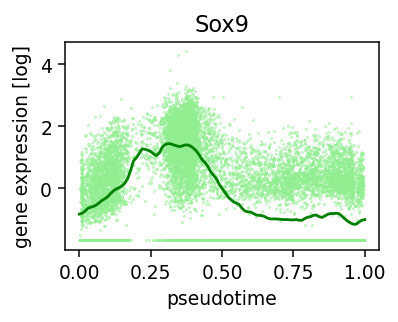

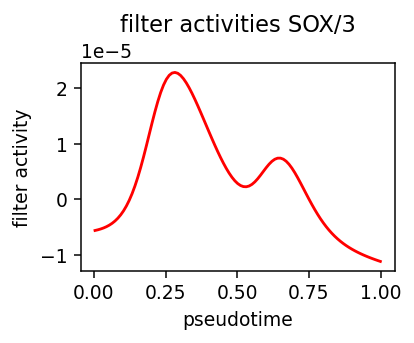

In [140]:
plot_pseudotime('Sox9', 'SOX/3', sigma_gex=.01, sigma_filter=.1)

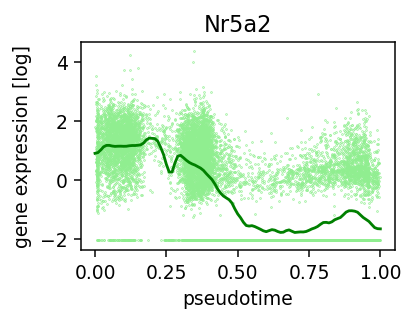

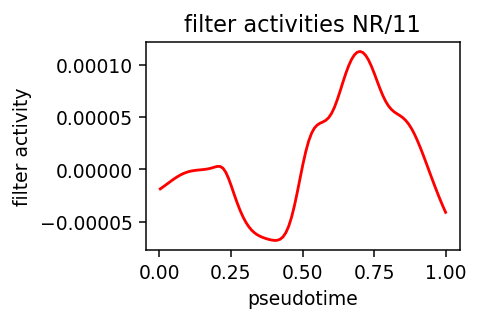

In [141]:
plot_pseudotime('Nr5a2', 'NR/11', sigma_gex=.01, sigma_filter=.05)